**Data Source:** Pleschberger, Martin, Zernig, Anja, & Kaestner, Andre. (2020). Equipment Sensor Data from Semiconductor Frontend Production (Version 1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4282611

In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 1000

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.choose_colorbrewer_palette
#plt.style.use('seaborn')

%matplotlib inline

In [2]:
sensors_1_to_24 = pd.read_csv('equipment1.csv', sep=';')
sensors_25_to_56 = pd.read_csv('equipment2.csv', sep=';')
response = pd.read_csv('response.csv', sep=';')

sensors_1_to_24.lot = sensors_1_to_24.lot.str.replace('lot', '').astype('int64')
sensors_1_to_24.timestamp = sensors_1_to_24.timestamp.str.replace('timestamp_', '').astype('int64')

sensors_25_to_56.lot = sensors_25_to_56.lot.str.replace('lot', '').astype('int64')
sensors_25_to_56.timestamp = sensors_25_to_56.timestamp.str.replace('timestamp_', '').astype('int64')

grouped_data_1_to_24 = sensors_1_to_24.groupby(['lot', 'wafer']).mean().sort_values('lot')
grouped_data_25_to_56 = sensors_25_to_56.groupby(['lot', 'wafer']).mean().sort_values('lot')

response['lot'] = response['lot'].str.replace('lot', '').astype('int64')
response['class'] = response['class'].replace(['good', 'bad'], [1, 0]).astype('int64')
grouped_response = response.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [3]:
print(len(grouped_response.index) - len(grouped_data_25_to_56.index))
print(len(grouped_response.index) - len(grouped_data_1_to_24.index))
print(len(grouped_response.index))

0
348
1319


In [4]:
sensor_data = grouped_data_1_to_24.join(grouped_data_25_to_56, how='outer', lsuffix='_1_to_24', rsuffix='_25_to_56')
data = sensor_data.join(grouped_response, how='outer')

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1319 entries, (2, 1) to (103, 25)
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_1_to_24   971 non-null    float64
 1   sensor_1            971 non-null    float64
 2   sensor_2            971 non-null    float64
 3   sensor_3            971 non-null    float64
 4   sensor_4            971 non-null    float64
 5   sensor_5            971 non-null    float64
 6   sensor_6            971 non-null    float64
 7   sensor_7            971 non-null    float64
 8   sensor_8            971 non-null    float64
 9   sensor_9            971 non-null    float64
 10  sensor_10           971 non-null    float64
 11  sensor_11           971 non-null    float64
 12  sensor_12           971 non-null    float64
 13  sensor_13           971 non-null    float64
 14  sensor_14           971 non-null    float64
 15  sensor_15           971 non-null    float64
 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1319 entries, (2, 1) to (103, 25)
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_1_to_24   971 non-null    float64
 1   sensor_1            971 non-null    float64
 2   sensor_2            971 non-null    float64
 3   sensor_3            971 non-null    float64
 4   sensor_4            971 non-null    float64
 5   sensor_5            971 non-null    float64
 6   sensor_6            971 non-null    float64
 7   sensor_7            971 non-null    float64
 8   sensor_8            971 non-null    float64
 9   sensor_9            971 non-null    float64
 10  sensor_10           971 non-null    float64
 11  sensor_11           971 non-null    float64
 12  sensor_12           971 non-null    float64
 13  sensor_13           971 non-null    float64
 14  sensor_14           971 non-null    float64
 15  sensor_15           971 non-null    float64
 

In [6]:
data.describe()

,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class
count,971.0,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,1319.0,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1.319000e+03,1319.000000,1319.000000,1319.000000
mean,87.5,4.067866,4.121005,37.679053,32.396468,32.348691,0.137369,10.663262,0.962059,7.350330,11.727677,12.926142,0.296606,0.263935,0.263935,0.263554,0.263539,6.213089,394.627237,106.444442,13.367926,313.857465,210.804377,469.115216,0.951073,87.5,0.001403,154.539367,61.388629,7.010709,0.001700,20.873311,10.445576,75.038648,0.000202,0.001861,38.326207,0.000207,23.872753,41.882245,39.580997,189.514677,2.650611,122.333376,124.302022,1.040673,453.448962,30.591545,783.977135,15.756765,176.676296,30.255056,175.282816,123.584465,198.086621,195.264637,5.419853e-01,0.617882,0.610433,0.799848
std,0.0,1.198389,1.183829,26.205390,11.573819,11.528880,0.559614,1.422817,0.689784,0.230095,0.337128,0.458412,1.098912,0.004763,0.004763,0.005090,0.005104,0.151641,10.060235,25.488229,3.742843,454.613894,3.732648,12.521195,0.081925,0.0,0.000049,79.418785,4.539808,0.561165,0.001149,0.716157,0.336480,2.559284,0.007353,0.000053,2.818333,0.007509,1.999914,1.827950,1.694330,10.079443,0.658755,9.044779,9.225132,0.090416,226.612973,1.590658,407.874725,0.600415,4.661447,1.611555,4.716476,9.136877,197.519613,196.568782,1.158684e-01,0.045494,0.442395,0.400265
min,87.5,2.212025,2.727273,13.161544,19.433870,19.431818,0.000000,8.397660,0.000000,6.937500,10.993409,12.090909,0.000000,0.254773,0.254773,0.253977,0.253977,5.965909,377.069847,73.119232,9.596591,0.250000,202.351875,433.028409,0.846875,87.5,0.001222,4.216210,50.625000,5.585227,0.000000,18.742386,9.322899,64.197888,0.000000,0.001696,31.725676,0.000000,19.200304,36.798038,35.246175,161.202755,0.962720,101.008813,102.426010,0.892045,14.255641,26.636136,72.361073,13.941364,158.500000,25.422727,153.122727,102.367403,0.000003,0.000002,2.907170e-07,0.511534,0.360000,0.000000
25%,87.5,2.812509,2.812500,13.588334,19.822606,19.857955,0.000000,9.351565,0.557398,7.153409,11.474176,12.522727,0.000000,0.260739,0.260739,0.259886,0.259830,6.085227,386.319659,95.938347,9.840909,79.354545,208.896551,455.767045,0.863750,87.5,0.001373,103.390709,60.187500,6.778409,0.000000,20.446023,10.218000,73.090327,0.000000,0.001817,37.687526,0.000000,22.598349,40.602276,38.329930,182.127009,2.208014,119.956132,121.636887,1.011364,295.523954,29.430682,452.774723,15.326705,173.210227,29.096591,172.103693,121.243535,0.000007,0.000007,4.892623e-01,0.607131,0.396000,1.000000
50%,87.5,5.119721,5.130682,13.924515,42.540133,42.656080,0.000000,9.926390,0.669504,7.284091,11.634716,12.875000,0.000000,0.266520,0.266520,0.266511,0.266511,6.164773,395.671869,101.606156,10.159091,87.622159,212.137693,468.323864,1.011307,87.5,0.001403,147.633078,61.312500,6.937500,0.002045,21.013977,10.463086,75.162172,0.000000,0.001860,38.053884,0.000000,24.341112,41.898304,39.577587,190.54430

In [7]:
data[['sensor_33']].value_counts()
zeros = (data['sensor_33'] == 0.0).sum()
total = data['sensor_33'].shape[0]
print(zeros * 100 / total)

bad_class_sum = (data['class']==0).sum()
good_class_sum = (data['class']==1).sum()
print(bad_class_sum * 100 / (bad_class_sum + good_class_sum))

99.92418498862774
20.015163002274452


Dropping sensor columns if more than 95% of the sensor values are 0.0

In [8]:
columns_before = data.columns;

In [9]:
data.head();

In [10]:
for n in data.columns:
    if ((data[n]==0).sum() * 100 / data[n].shape[0]) >= 95:
        data = data.drop(n, axis=1)
        
columns_after = data.columns;
print('Columns that were dropped for having < 95% of non zero values', set(columns_before) - set(columns_after))

Columns that were dropped for having < 95% of non zero values {'sensor_36', 'sensor_33'}


In [11]:
#ECDF plots
def ECDF(df_column):
    '''returns sorted data as x and proportionate 0.0 to 1.0 y values'''
    x = np.sort(df_column)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def ECDF_plot():
    plt.figure(figsize=(40.0,40.0))
    for ax, n in list(enumerate(data.columns)):
        x, y = ECDF(data[n])
        plt.subplot(10, 10, ax+1)
        plt.grid(True)
        x_ecdf = plt.plot(x, y, marker='.', linestyle='none')
        plt.xlabel('%s readings' %n)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.ylabel('ECDF')
        plt.margins(0.02)
        
#ECDF_plot()     #Uncomment for ECDF plots


In [12]:
data[['sensor_12']].value_counts();
zeros = (data['sensor_12'] == 0.0).sum()
total = data['sensor_12'].shape[0]
print(zeros * 100 / total)

68.6125852918878


Well sensor 12 barely made the cut of having less than 95% of non zero values. Keeping sensor 12 column for now

In [13]:
lot_wafer_dict = dict(enumerate(data.index))
data['new_index'] = list(lot_wafer_dict.keys())

In [14]:
print(data.shape)
data.head()

(1319, 59)


timestamp_1_to_24  sensor_1  sensor_2   sensor_3   sensor_4  \
lot wafer                                                                
2   1                   87.5  5.231203  5.176705  13.251176  42.618787   
    2                   87.5  5.196315  5.142614  13.666808  43.419169   
    3                   87.5  5.161432  5.255114  13.243853  42.981363   
    4                   87.5  5.175509  5.294318  13.671360  43.151993   
    5                   87.5  5.201729  5.127273  13.332878  43.262745   

            sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  \
lot wafer                                                                 
2   1      43.066761       0.0  8.505448       0.0  7.267045  11.703011   
    2      43.147443       0.0  9.167583       0.0  7.607955  11.960227   
    3      42.650795       0.0  8.666924       0.0  7.295455  11.563523   
    4      42.904432       0.0  9.621476       0.0  7.613636  12.191591   
    5      43.001705       0.0  9.275963       0.0  7.335227  11.556989   

           sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  \
lot wafer                                                                     
2   1      12.346591        0.0   0.266298   0.266298   0.266298   0.266298   
    2      12.761364        0.0   0.266162   0.266162   0.266162   0.266162   
    3      12.551136        0.0   0.266903   0.266903   0.266903   0.266903   
    4      13.215909        0.0   0.267062   0.267062   0.267062   0.267062   
    5      12.568182        0.0   0.266392   0.266392   0.266392   0.266392   

           sensor_17   sensor_18   sensor_19  sensor_20  sensor_21  \
lot wafer                                                            
2   1       6.164773  398.018165  126.723761   9.778409  79.217614   
    2       6.363636  408.363824  201.201568  10.329545  88.847159   
    3       6.164773  398.137699  113.195898   9.727273  79.772727   
    4       6.363636  408.062517  179.183085  10.164773  88.403409   
    5       6.204545  398.231636  107.544619   9.715909  80.952273   

            sensor_22   sensor_23  sensor_24  timestamp_25_to_56  sensor_25  \
lot wafer                                                                     
2   1      208.905500  467.232955   0.983864                87.5   0.001495   
    2      208.953966  467.204545   1.017557                87.5   0.001500   
    3      212.313545  477.465909   0.987557                87.5   0.001505   
    4      212.313250  477.437500   1.015966                87.5   0.001509   
    5      208.906159  467.227273   1.011364                87.5   0.001499   

            sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  \
lot wafer                                                                      
2   1      232.694903    60.1875     6.6875        0.0  21.821591  11.296246   
    2      245.951321    63.5625     7.0625        0.0  22.105284  10.849002   
    3      243.975941    63.0000     7.0000        0.0  21.821420  11.063067   
    4      246.357599    63.5625     7.0625        0.0  22.105057  10.858582   
    5      246.561347    63.5625     7.0625        0.0  22.104545  11.069689   

           sensor_32  sensor_34  sensor_35  sensor_37  sensor_38  sensor_39  \
lot wafer                                                                     
2   1      79.692877   0.001977  37.624962  21.595660  44.118530  42.609528   
    2      80.814970   0.001973  39.854000  22.763340  45.344954  43.932713   
    3      80.783452   0.001954  39.408217  22.018238  44.152238  43.927304   
    4      80.050300   0.001954  39.754566  21.757269  44.262521  41.514607   
    5      80.733545   0.001977  39.854118  22.053265  44.748803  43.069595   

            sensor_40  sensor_41   sensor_42   sensor_43  sensor_44  \
lot wafer                                                             
2   1      189.509110   1.660068  120.094154  122.751516   1.022727   
    2      196.958829   2.555232  126.8

In [15]:
#sns.heatmap(data.corr())
print(data.corr()['class'].sort_values().head())
print(data.corr()['response'].sort_values().head())

response    -0.896568
sensor_24   -0.421485
sensor_2    -0.408268
sensor_1    -0.407393
sensor_5    -0.407297
Name: class, dtype: float64
class       -0.896568
sensor_3    -0.373243
sensor_20   -0.372276
sensor_7    -0.338698
sensor_47   -0.316494
Name: response, dtype: float64


This is interesting, I expected response and class to both have the sensor with the highest correlation. Maybe the response threshold to classify class as good or bad (1 or 0) needs to be revisited. Per data author, threshold is set at 0.75 response units.

In [16]:
data.tail()

timestamp_1_to_24  sensor_1  sensor_2   sensor_3   sensor_4  \
lot wafer                                                                
103 21                  87.5  5.173926  5.280682  13.752672  43.031671   
    22                  87.5  5.210645  5.137500  13.751966  43.102054   
    23                  87.5  5.124964  5.222727  13.755941  43.156936   
    24                  87.5  5.173762  5.261932  13.665262  42.282424   
    25                  87.5  5.118307  5.193750  13.751466  43.329691   

            sensor_5  sensor_6   sensor_7  sensor_8  sensor_9  sensor_10  \
lot wafer                                                                  
103 21     42.775000       0.0   9.814747  1.690483  7.670455  12.325284   
    22     43.077273       0.0   9.449443  0.000000  7.642045  11.887898   
    23     42.942330       0.0   9.749346  1.776488  7.607955  12.101364   
    24     42.671932       0.0   9.147259  0.000000  7.607955  11.992614   
    25     43.050284       0.0  10.050516  1.707476  7.607955  12.024148   

           sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  \
lot wafer                                                                     
103 21     13.715909        0.0   0.267886   0.267886   0.267886   0.267886   
    22     13.289773        0.0   0.266841   0.266841   0.266841   0.266841   
    23     13.704545        0.0   0.267622   0.267622   0.267622   0.267622   
    24     13.215909        0.0   0.267437   0.267437   0.267437   0.267437   
    25     13.715909        0.0   0.267452   0.267452   0.267452   0.267452   

           sensor_17   sensor_18  sensor_19  sensor_20  sensor_21   sensor_22  \
lot wafer                                                                       
103 21      6.403409  405.964540  95.299691  10.085227  87.831818  215.722295   
    22      6.403409  404.200278  79.554207   9.863636  81.342614  212.315114   
    23      6.403409  406.395460  95.068045  10.170455  88.921591  215.723068   
    24      6.363636  403.238483  79.097036   9.829545  81.233523  212.313455   
    25      6.403409  404.578426  95.215091  10.107955  88.681818  215.723455   

            sensor_23  sensor_24  timestamp_25_to_56  sensor_25   sensor_26  \
lot wafer                                                                     
103 21     487.664773   1.022273                87.5   0.001384  132.332135   
    22     477.431818   1.016534                87.5   0.001383  132.512172   
    23     490.448864   1.022898                87.5   0.001384  132.693170   
    24     474.653409   1.017216                87.5   0.001378  132.872920   
    25     487.664773   1.023125                87.5   0.001368  140.450273   

           sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  sensor_32  \
lot wafer                                                                     
103 21        60.750   6.926136   0.001761  20.445852  10.204585  73.789450   
    22        60.750   6.914773   0.001307  20.445341  10.001607  73.715944   
    23        60.750   6.920455   0.000909  20.446193  10.112931  72.487895   
    24        60.750   6.914773   0.001648  20.445852  10.256243  72.430714   
    25        64.125   7.125000   0.001364  20.446364  10.111772  72.433536   

           sensor_34  sensor_35  sensor_37  sensor_38  sensor_39   sensor_40  \
lot wafer                                                                      
103 21      0.001813  38.070877  23.401281  41.574534  38.932325  190.806143   
    22      0.001813  38.071100  23.200310  40.660226  37.094139  185.562074   
    23      0.001813  38.056004  24.859580  40.848537  38.768152  191.773287   
    24      0.001813  38.071562  23.271924  41.682737  38.825995  188.094159   
    25      0.001794  40.169774  25.894782  41.056204  37.992842  190.879406   

           sensor_41   sensor_42   sensor_43  sensor_44   sensor_45  \
lot wafer                                                             
103 21      3.154504  122.

In [17]:
print(data.isna().sum(), '\n', '\n')
data = data.fillna(0)
data.sample(5)

timestamp_1_to_24     348
sensor_1              348
sensor_2              348
sensor_3              348
sensor_4              348
sensor_5              348
sensor_6              348
sensor_7              348
sensor_8              348
sensor_9              348
sensor_10             348
sensor_11             348
sensor_12             348
sensor_13             348
sensor_14             348
sensor_15             348
sensor_16             348
sensor_17             348
sensor_18             348
sensor_19             348
sensor_20             348
sensor_21             348
sensor_22             348
sensor_23             348
sensor_24             348
timestamp_25_to_56      0
sensor_25               0
sensor_26               0
sensor_27               0
sensor_28               0
sensor_29               0
sensor_30               0
sensor_31               0
sensor_32               0
sensor_34               0
sensor_35               0
sensor_37               0
sensor_38               0
sensor_39   

,,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_34,sensor_35,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class,new_index
lot,wafer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,24,87.5,5.141113,5.205682,13.327757,43.407978,43.228409,0.0,9.129315,0.183631,7.301136,11.435284,12.471591,0.0,0.266886,0.266886,0.266886,0.266886,6.204545,397.600966,102.259983,9.755682,80.877273,208.905114,477.460227,1.022557,87.5,0.001471,173.361463,61.363636,6.750000,0.002898,21.298466,10.585705,77.927978,0.001907,38.060190,27.860799,43.500735,41.079925,201.465509,2.866104,122.075082,123.759149,1.028409,489.213002,32.054205,1150.508534,16.400227,184.102273,31.357955,178.146023,122.764173,0.000007,401.434886,0.504586,0.613636,0.3870,1,271
74,20,87.5,2.760009,2.812500,66.084646,19.863811,19.857955,0.0,11.984558,0.699234,7.153409,11.257443,12.755682,0.0,0.260739,0.260739,0.259886,0.259830,6.085227,383.440744,99.494169,17.772727,1130.113636,209.263812,455.761364,0.864318,87.5,0.001414,48.866800,59.625000,6.625000,0.001818,21.581989,10.338383,75.197806,0.001837,37.370933,26.255109,41.721646,39.559691,195.673068,2.390986,119.926131,121.592859,1.005682,187.861294,30.934205,1026.846256,15.860170,179.460227,30.380682,175.982955,120.513952,381.830947,0.000007,0.475362,0.602273,0.3690,1,1138
10,11,87.5,5.170347,5.270455,13.838410,43.394147,43.174432,0.0,9.295385,1.901512,7.710227,12.206023,13.767045,0.0,0.267256,0.267256,0.267256,0.267256,6.443182,409.142994,162.868062,10.079545,89.989205,215.722432,477.426136,1.028011,87.5,0.001445,238.407387,61.363636,7.363636,0.002386,22.150057,10.856991,76.527121,0.001930,38.083671,25.025351,44.421079,41.049961,204.968207,3.024245,122.038498,123.729499,1.028409,722.137381,32.750909,1383.076739,16.535114,182.267045,32.025000,180.353409,122.720821,0.000007,395.926391,0.537304,0.613693,0.4320,1,208
60,12,87.5,2.824799,2.897727,65.257217,19.821068,19.801136,0.0,12.333942,0.682032,7.136364,11.555227,12.880682,0.0,0.260739,0.260739,0.259886,0.259830,6.085227,386.688455,103.368695,17.386364,0.514205,211.462500,455.761364,0.863352,87.5,0.001314,40.601340,61.931818,7.085227,0.001818,19.310455,9.729336,71.097945,0.001771,38.422907,23.292906,38.583165,36.430987,175.634455,2.591299,122.247792,123.956818,1.039773,85.543443,27.606932,85.541934,14.723352,170.636364,27.109091,170.172159,123.869428,374.417586,0.000006,0.488897,0.620398,0.4122,1,931
25,24,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.5,0.001423,88.356068,60.795455,6.687500,0.002216,21.298295,10.570460,75.227270,0.001864,37.721284,24.914548,43.073754,40.936976,196.622869,3.165463,120.586605,122.254714,1.017045,219.302130,31.734432,874.536801,16.176875,181.727273,31.152841,179.376136,121.635508,391.628610,0.000007,0.496567,0.607955,0.4806,1,495


**Classification**

In [18]:
X = data.drop('class', axis=1).values
y = data['class'].values

Logistic regression complains if the target value is continuous. This makes sense as logistic regression is a classification method. So for logistic regression use 'class' column as target.

In [19]:
data['response'].head();
print(X.shape)
print(y.shape)

(1319, 58)
(1319,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=314)

In [21]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test);

In [22]:
X_train.max()

7.502288479941538

In [23]:
print(type(X_train))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
(131, 58)
(131,)
(1188, 58)
(1188,)


In [24]:
log_reg = LogisticRegression()
rand_for = RandomForestClassifier()

In [25]:
log_reg.fit(X_train, y_train)
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       234
           1       0.98      1.00      0.99       954

    accuracy                           0.99      1188
   macro avg       0.99      0.97      0.98      1188
weighted avg       0.99      0.99      0.99      1188

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       101

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131



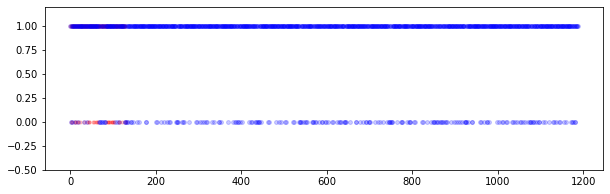

In [26]:
plt.figure(figsize=(10,3))
plt.ylim(-0.5, 1.2)
#plt.scatter(np.arange(len(y_test)), y_test, c='green', s=15, alpha=0.4);
plt.scatter(np.arange(len(y_train)), y_pred_train, c='red', s=10, alpha=0.2);
plt.scatter(np.arange(len(y_test)), y_pred_test, c='blue', s=15, alpha=0.2);

print(classification_report(y_test, y_pred_test, labels=[0,1]))
print(classification_report(y_train, y_pred_train, labels=[0,1]))

In [27]:
rand_for.fit(X_train, y_train)
y_pred_train = rand_for.predict(X_train)
y_pred_test = rand_for.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       234
           1       0.96      0.99      0.98       954

    accuracy                           0.96      1188
   macro avg       0.95      0.92      0.93      1188
weighted avg       0.96      0.96      0.96      1188

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       101

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131



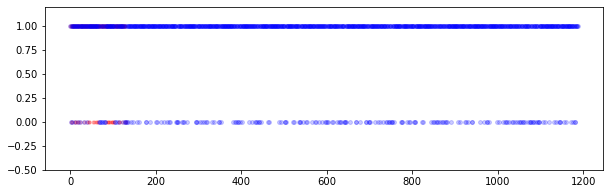

In [28]:
plt.figure(figsize=(10,3))
plt.ylim(-0.5, 1.2)
#plt.scatter(np.arange(len(y_test)), y_test, c='green', s=15, alpha=0.4);
plt.scatter(np.arange(len(y_train)), y_pred_train, c='red', s=10, alpha=0.2);
plt.scatter(np.arange(len(y_test)), y_pred_test, c='blue', s=15, alpha=0.2);

print(classification_report(y_test, y_pred_test, labels=[0,1]))
print(classification_report(y_train, y_pred_train, labels=[0,1]))

With a train/test split of only 10/90, my precision and recall are above 94%. Too good to be true?

**Regression**

In [29]:
#X = data.drop('response', axis=1).astype('float')
#y = data['response'].astype('float')
X = data.drop('response', axis=1).values
y = data['response'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [31]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test)

In [32]:
lin_reg = LinearRegression()
lasso_reg = Lasso(alpha=20)

In [33]:
lin_reg.fit(X_train, y_train)
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

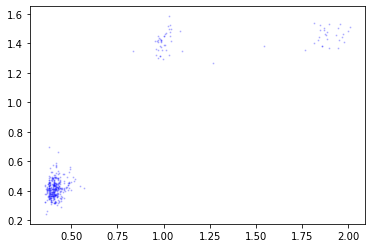

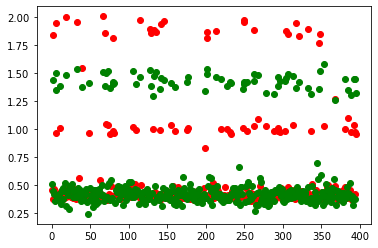

In [34]:
plt.scatter(y_test, y_pred_test, c='blue', alpha=0.2, s=1)
plt.show()
plt.scatter(np.arange(len(y_test)), y_test, c='red')
plt.scatter(np.arange(len(y_test)), y_pred_test, c='green')
plt.show()

In [35]:
lasso_reg.fit(X_train, y_train)
y_pred_train = lasso_reg.predict(X_train)
y_pred_test = lasso_reg.predict(X_test)
print(lasso_reg.coef_)

[-0.  0.  0. -0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0. -0.  0.]


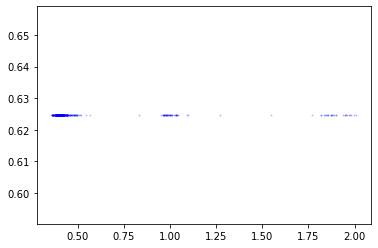

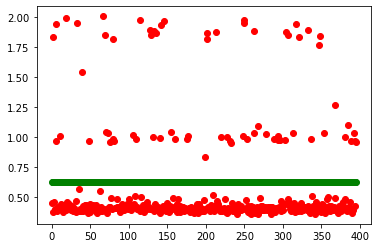

In [36]:
plt.scatter(y_test, y_pred_test, c='blue', alpha=0.2, s=1)
plt.show()
plt.scatter(np.arange(len(y_test)), y_test, c='red')
plt.scatter(np.arange(len(y_test)), y_pred_test, c='green')
plt.show()

In [37]:
### Code blocks below are scratch work ###

In [38]:
#X = X_pca
#pca = PCA(n_components=2)
#pca.fit(X_train)
#pca.transform(X_test)
#X_pca = pd.DataFrame(normalize(X_pca), columns=['PCA1', 'PCA2'])

In [39]:
#plt.scatter(y_test, y_pred_test, alpha=0.5)
#plt.figure(figsize=(20,3))
#plt.scatter(X_test['PCA1'], y_test, c='green', s=15, alpha=0.4);
#plt.scatter(X_test['PCA1'], y_pred_test, c='red', s=15, alpha=0.2);